### Data downloaded from https://simplemaps.com/data/us-cities

In [92]:
import pandas as pd
import requests
import json 
import numpy as np
import matplotlib.pyplot as pl

In [226]:
import os
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point

### Finding driving distance
We use Open Source Routing Machine (OSRM) api to calculate this. 

http://project-osrm.org/docs/v5.24.0/api/?language=Python#general-options

In [341]:
def distance_between(loc1,loc2):

    """
    input:
        loc1: source location (lat,long)
        loc2: destination location (lat,long)
    output:
        distance: road distance in Km
        duration: time in mins
    """

    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{loc1[1]},{loc1[0]};{loc2[1]},{loc2[0]}?overview=false""")
    # print(r.content)
    try: 
        content = json.loads(r.content)['routes'][0]
    except: 
        print(r.content)
        return False
    distance,duration = content['distance'],content['duration']

    return distance/1000, duration/60


In [281]:
def get_city_data():
    final_file = 'cities_data/simplemaps_uscities_basicv1.76/uscitites_clean.csv'
    if os.path.isfile(final_file):
        with open(final_file,'rb') as f:
            data = pickle.load(f)
        return data
    
    file_name = 'cities_data/simplemaps_uscities_basicv1.76/uscities.csv'
    city_data = pd.read_csv(file_name)
    required_cols = ['city','state_id','state_name','county_name','lat','lng','population','density']
    city_data_filtered = city_data.filter(required_cols,axis=1)
    with open(final_file,'wb') as f:
        pickle.dump(city_data_filtered,f)
    return city_data_filtered

In [282]:
city_data = get_city_data()

In [419]:
city_data.head()

,city,state_id,state_name,county_name,lat,lng,population,density
0,New York,NY,New York,Queens,40.6943,-73.9249,18972871,10768.2
1,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
2,Chicago,IL,Illinois,Cook,41.8375,-87.6866,8595181,4576.6
3,Miami,FL,Florida,Miami-Dade,25.7840,-80.2101,5711945,4945.7
4,Dallas,TX,Texas,Dallas,32.7935,-96.7667,5668165,1522.2


In [420]:
loc1= (city_data.loc[city_data['city']=="Santa Barbara"][['lat','lng']]).values[0]
loc2 = (city_data.loc[city_data['city']=="Burbank"][['lat','lng']]).values[0]
print(loc1,loc2)
distance_between(loc1,loc2)

[  34.4285 -119.7202] [  34.1879 -118.3235]


(146.6678, 109.50333333333333)

### US state grid

In [401]:

def state_polygon(state_name):
    """Returns Polygon of a US state

    Args:
        state_name (str): US state name

    Returns:
        polygon: Polygon for the state boundary
    """
    boundaries = pd.read_csv('cities_data/us-state-boundaries.csv',sep=';')
    assert state_name in boundaries['name'].values, "State not in the list"
    
    boundaries = boundaries.filter(['name','St Asgeojson'],axis=1)
    state = json.loads((boundaries.loc[boundaries['name']==state_name]).values[0][1])
    polygon = Polygon(state['coordinates'][0][0])
    return polygon

def state_grid(state_name,resolution):
    """creates grid of points inside the state

    Args:
        state_name (str): name of the US state
        resolution (float): distance resolution for the grid (units of miles)
    output:
        valid_points: list of (latitude,longitude) of points inside the state
    """

    polygon = state_polygon(state_name)
    

    ## Creating grid points inside the state
    x_min,y_min,x_max,y_max = polygon.bounds
    lat_dist_per_degree = 111/1.6 #in miles
    long_dist_per_degree = np.cos((y_min+y_max)*0.5)*111/1.6 #in miles
    resolution_lat = resolution/lat_dist_per_degree
    resolution_long = resolution/long_dist_per_degree
    gridx_points = np.arange(x_min,x_max,resolution_long)
    gridy_points = np.arange(y_min,y_max,resolution_lat)
    # print(grid_points[0].flatten(),grid_points[1].flatten())
    valid_points = []
    invalid_points = []
    for x in gridx_points:
        for y in gridy_points:
            # print(Point(x,y).within(polygon))
            if Point(x,y).within(polygon):
                valid_points.append((x,y))
            else:
                invalid_points.append((x,y))
    return valid_points, polygon

In [402]:
CA_grid, CA_polygon = state_grid('California',25)

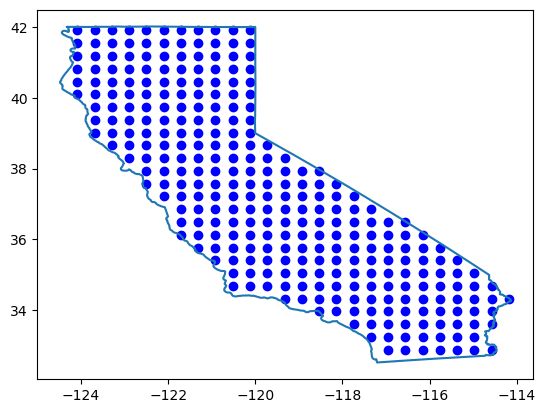

In [403]:
colors = ['blue','red']
pl.plot(*CA_polygon.exterior.xy)
[pl.scatter(*p,color='blue') for p in CA_grid]
# [pl.scatter(*p,color='red') for p in invalid_points]



In [404]:
len(CA_grid) #total number of grid points

301

## Driving distance to cities

In [421]:
cities = (city_data[city_data['state_name']==state_name].reset_index(drop=True)).copy(deep=True)
cities.sort_values(by='population',ascending=False,inplace=True)
population_threshold = 80000
cities = cities.loc[cities['population']>population_threshold]

In [422]:
cities

,city,state_id,state_name,county_name,lat,lng,population,density
0,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
1,San Francisco,CA,California,San Francisco,37.7558,-122.4449,3290197,7199.4
2,San Diego,CA,California,San Diego,32.8313,-117.1222,3084174,1675.9
3,Riverside,CA,California,Riverside,33.9381,-117.3949,2022285,1557.0
4,Sacramento,CA,California,Sacramento,38.5677,-121.4685,1924167,1971.3
...,...,...,...,...,...,...,...,...
111,Redwood City,CA,California,San Mateo,37.5025,-122.2253,83905,1687.6
112,Alhambra,CA,California,Los Angeles,34.0840,-118.1355,83174,4275.8
113,Madera,CA,California,Madera,36.9630,-120.0778,82772,1536.8
114,Lakewood,CA,California,Los Angeles,33.8471,-118.1222,82419,3272.3


In [435]:
aa = [0,2,1]
f = lambda x: aa[x]
f(2)

1

In [438]:
aa = [0,2,1]
bb = [1,2,4]
cc = [0,1,2]
sorted(cc,key=lambda i:aa[i]),aa,bb[cc]

TypeError: list indices must be integers or slices, not list

In [445]:
def distance_from_cities(lat,lng,radii=None):
    """Generate driving distance of a point from major cities in a state

    Args:
        lat (float): latitude of the location 
        lng (float): longitude of the location
        radii (float, optional): Threshold for the distance in miles. Defaults to None.

    Returns:
        distance_list: distance of to all cities within the radii
        population_list: population of cities within the radii
    """
    distance_list = []
    population_list = []
    city_name_list = []
    city_loc_list = []
    if radii is None:
        radii = 100000000 # some random value which is not possible in physical scenario
    lat_radii = radii/(111/1.6) # in miles
    lng_radii = abs(radii/(111*np.cos(lat)/1.6)) #in miles

    for index,city in cities.iterrows():
        city_lng,city_lat = city['lng'],city['lat']
        if abs(city_lng-lng) > lng_radii or abs(city_lat-lat) > lat_radii:
            continue
          
        dist,_ = distance_between((lat,lng),(city_lat,city_lng))
        distance_list.append(dist)
        city_name_list.append(city['city'])
        city_loc_list.append((city_lat,city_lng))
        population_list.append(city['population'])
    
    index = list(range(len(distance_list)))
    index = sorted(index,key=lambda x:distance_list[x])
    distance_list = [distance_list[x] for x in index]
    population_list = [population_list[x] for x in index]
    city_loc_list = [city_loc_list[x] for x in index]
    city_name_list = [city_name_list[x] for x in index]

    return distance_list, population_list, city_name_list, city_loc_list

In [448]:
dist_list_100, pop_list_100,name_list_100,loc_list_100 = distance_from_cities(locations[100][1],locations[100][0],radii=50)

In [449]:
dist_list_100

[105.44460000000001, 132.0532, 145.61, 174.80870000000002, 188.0765, 199.2641]

In [414]:
state_name = 'California' # state to focus on
locations,state_polygon = state_grid(state_name,resolution=25) # change this to change the dataset


In [450]:
locations[100],len(locations)

((-120.9140352674987, 36.1324356038088), 301)

In [456]:
# Generate a dataframe for a list of locations

radii = 50 #in mile
df = pd.DataFrame({'lng':[],'lat':[],'number of cities':[],'total population':[],'min distance':[],'max distance':[],'name of the nearest city':[],'coordinates of the nearest city (lat,lng)':[],'distance list':[],'population list':[],'cities name':[],'cities locations':[]})
nearest_dist = 0
nearest_city = ''
for loc in locations[100:110]:
    print(loc)
    # df['drivin radii'].append(radii)
    dist_list, pop_list, name_list, loc_list = distance_from_cities(loc[1],loc[0],radii=radii)
    
    city_count = len(dist_list)
    population = np.sum(pop_list)
    min_distance = dist_list[0]
    max_distance = dist_list[-1]
    name_of_the_nearest_city = name_list[0]
    coordinates = loc_list[0]

    print([loc[0],loc[1],radii,city_count,population])

    df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,
    'name of the nearest city':name_of_the_nearest_city,
    'coordinates of the nearest city (lat,lng)':coordinates,
     'distance list':dist_list,'population list':pop_list,'cities name':name_list,'cities locations':loc_list},ignore_index=True)

(-120.9140352674987, 36.1324356038088)
[-120.9140352674987, 36.1324356038088, 50, 6, 1498788]
(-120.9140352674987, 36.49279596416916)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 36.49279596416916, 50, 9, 1861954]
(-120.9140352674987, 36.85315632452952)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 36.85315632452952, 50, 9, 2862991]
(-120.9140352674987, 37.21351668488988)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 37.21351668488988, 50, 7, 1155507]
(-120.9140352674987, 37.57387704525024)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 37.57387704525024, 50, 7, 1363039]
(-120.9140352674987, 37.9342374056106)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 37.9342374056106, 50, 9, 3444164]
(-120.9140352674987, 38.29459776597096)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 38.29459776597096, 50, 10, 3504799]
(-120.9140352674987, 38.65495812633132)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 38.65495812633132, 50, 11, 4175637]
(-120.9140352674987, 39.01531848669168)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 39.01531848669168, 50, 9, 3060912]
(-120.9140352674987, 39.37567884705204)


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[-120.9140352674987, 39.37567884705204, 50, 4, 474876]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/4071952567.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


In [ ]:
# Add name, population, and distance of the nearest city.

In [457]:
df

,lng,lat,number of cities,total population,min distance,max distance,name of the nearest city,"coordinates of the nearest city (lat,lng)",distance list,population list,cities name,cities locations
0,-120.914035,36.132436,6.0,1498788.0,105.4446,199.2641,Salinas,"(36.6883, -121.6317)","[105.44460000000001, 132.0532, 145.61, 174.808...","[199290, 116189, 95459, 249804, 719558, 118488]","[Salinas, Seaside, Hanford, Visalia, Fresno, C...","[(36.6883, -121.6317), (36.6224, -121.8199), (..."
1,-120.914035,36.492796,9.0,1861954.0,113.9022,238.9331,Gilroy,"(37.0046, -121.5854)","[113.9022, 123.4647, 150.0733, 154.77339999999...","[114461, 199290, 116189, 165933, 95459, 249804...","[Gilroy, Salinas, Seaside, Santa Cruz, Hanford...","[(37.0046, -121.5854), (36.6883, -121.6317), (..."
2,-120.914035,36.853156,9.0,2862991.0,83.8419,176.2322,Turlock,"(37.5053, -120.8588)","[83.8419, 89.091, 107.25210000000001, 109.5359...","[103359, 157617, 114461, 82772, 199290, 172987...","[Turlock, Merced, Gilroy, Madera, Salinas, San...","[(37.5053, -120.8588), (37.3057, -120.4779), (..."
3,-120.914035,37.213517,7.0,1155507.0,42.0345,127.6342,Turlock,"(37.5053, -120.8588)","[42.0345, 53.975199999999994, 57.1456, 83.4845...","[103359, 157617, 382994, 98022, 114461, 99764,...","[Turlock, Merced, Modesto, Tracy, Gilroy, Mant...","[(37.5053, -120.8588), (37.3057, -120.4779), (..."
4,-120.914035,37.573877,7.0,1363039.0,11.1632,146.8729,Turlock,"(37.5053, -120.8588)","[11.163200000000002, 11.953, 39.8991, 54.7143,...","[103359, 382994, 99764, 157617, 98022, 406822,...","[Turlock, Modesto, Manteca, Merced, Tracy, Sto...","[(37.5053, -120.8588), (37.6375, -121.0028), (..."
5,-120.914035,37.934237,9.0,3444164.0,41.2052,115.3535,Stockton,"(37.9765, -121.3109)","[41.2052, 42.149, 48.829800000000006, 60.5276,...","[406822, 382994, 99764, 103359, 98022, 175510,...","[Stockton, Modesto, Manteca, Turlock, Tracy, E...","[(37.9765, -121.3109), (37.6375, -121.0028), (..."
6,-120.914035,38.294598,10.0,3504799.0,59.0471,122.8137,Stockton,"(37.9765, -121.3109)","[59.0471, 65.2903, 66.16, 67.02839999999999, 6...","[406822, 95909, 175510, 1924167, 87521, 99764,...","[Stockton, Arden-Arcade, Elk Grove, Sacramento...","[(37.9765, -121.3109), (38.6017, -121.3845), (..."
7,-120.914035,38.654958,11.0,4175637.0,44.9994,170.2445,Citrus Heights,"(38.6948, -121.288)","[44.9994, 53.474199999999996, 54.3638000000000...","[87521, 95909, 145687, 1924167, 175510, 129536...","[Citrus Heights, Arden-Arcade, Roseville, Sacr...","[(38.6948, -121.288), (38.6017, -121.3845), (3..."
8,-120.914035,39.015318,9.0,3060912.0,56.2782,222.1579,Roseville,"(38.7703, -121.3196)","[56.2782, 58.7188, 72.0364, 79.75789999999999,...","[145687, 87521, 95909, 1924167, 129536, 175510...","[Roseville, Citrus Heights, Arden-Arcade, Sacr...","[(38.7703, -121.3196), (38.6948, -121.288), (3..."
9,-120.914035,39.375679,4.0,474876.0,87.3651,150.2764,Yuba City,"(39.1357, -121.6383)","[87.36510000000001, 95.18780000000001, 97.6284...","[129536, 145687, 87521, 112132]","[Yuba City, Roseville, Citrus Heights, Chico]","[(39.1357, -121.6383), (38.7703, -121.3196), (..."


In [ ]:
with open()